1а. После каждого опыта необходимо вычислить ряд распределения апостериорных вероятностей определенных сочетаний карт. Представить соответствующие результаты визуально на графике в форме диаграмм распределений вероятностей конфигураций по ходу изменения числа опытов.
Рассмотреть 3 случая – карты по мастям, карты по номиналам и карты по мастям и номиналам.

Вычислим ряд распределения апостериорных вероятностей определенных сочетаний карт после каждого опыта. Мы можем ограничиться только теми номиналами, которые встречаются в экспериментах. Это уменьшит количество возможных гипотез.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



f = open('task_1_cards_me.txt', 'r', encoding='utf-8')
info = f.readline().split(', ')
N = int(info[0].split('=')[1])
d = int(info[1].split('=')[1])
p1 = float(info[2].split('=')[1])
p2 = float(info[3].split('=')[1])
n_exp = int(info[4].split('=')[1])

info_list = []
list_of_suits = set([])
list_of_values = set([])
for i in range(n_exp):
    s = f.readline().rstrip().split('cards:')
    b = s[1].split(', ')
    lst = []
    for k in range(d):
        lst.append([b[k].split(':')[0], b[k].split(':')[1]])
        list_of_suits.add(b[k].split(':')[0])
        list_of_values.add(b[k].split(':')[1])
    info_list.append(lst)
f.close()
cards = []
print(list_of_suits)
print(list_of_values)
for suit in list_of_suits:
    for val in list_of_values:
        cards.append([suit, val])
hyps = list(itertools.combinations(cards, N))

{'♡', '♣', '♢', '♠'}
{'2', '4', '7', '3', '10', 'A', '5'}


Карты которые встречаются в экспериментах представлены выше. Получается в нашем случае будет выбор из 4х8=32 карт, а не из 52. Также стоит посчитать, что ведущий выбирает ложный номинал только из этих карт - равновероятно из оставшихся номиналов (в нашем случае выбор из 8-1=7 вариантов).

# Карты по мастям

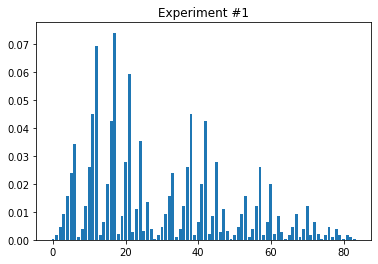

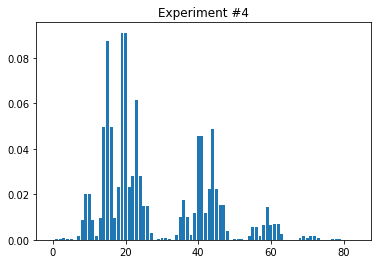

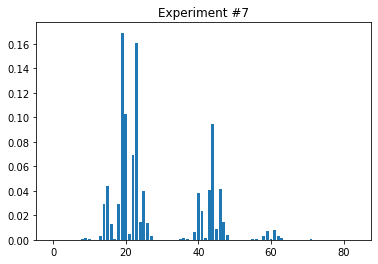

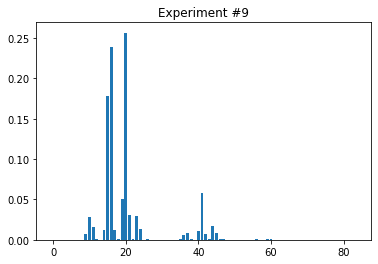

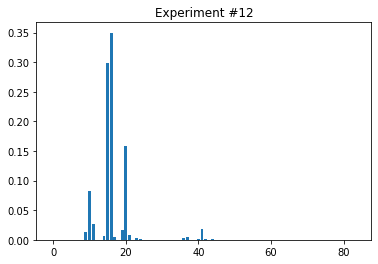

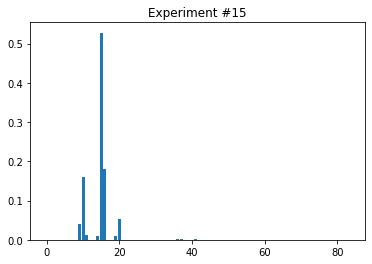

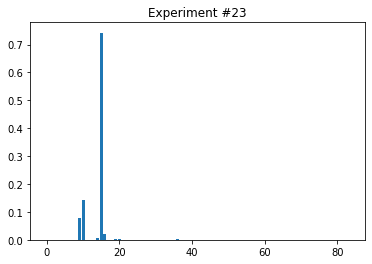

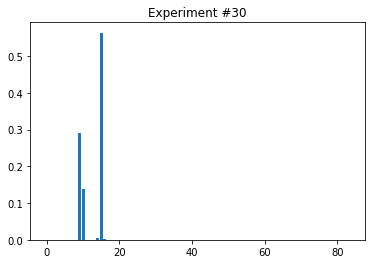

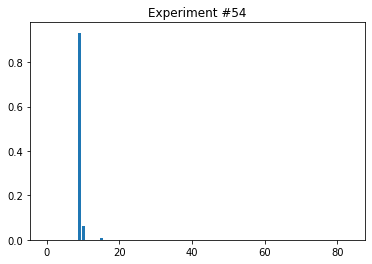

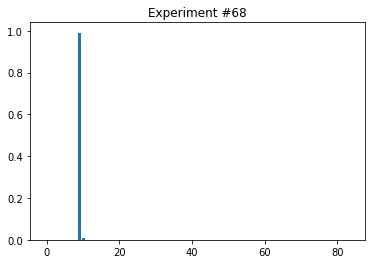

In [2]:

def combs_with_sum(lst, S, val_max):
    if len(lst) == 1:
        if S <= val_max:
            return [{lst[0]: S}]
        else:
            return []
    else:
        pv = []
        for k in range(S + 1):
            if k > val_max:
                break
            pv_prev = combs_with_sum(lst[1:], S - k, val_max)
            for dct in pv_prev:
                dct_new = dct.copy()
                dct_new[lst[0]] = k
                pv.append(dct_new)
    return pv


def pi_set_suit(hyp, set_of_suits):
    all_perms = list(itertools.product(list(hyp), repeat=d))
    sum_p = 0
    for perm in all_perms:
        p = 1
        hyp_suits = {s: hyp[s] for s in list_of_suits}
        for k in range(d):
            if set_of_suits[k][0] == perm[k]:
                p *= 1 - p1
            else:
                p *= p1 / 3
            p *= hyp_suits[perm[k]] / (N - k)
            hyp_suits[perm[k]] -= 1
            if hyp_suits[perm[k]] < 0:
                p = 0
                break
        sum_p += p
    return sum_p


hyps_about_suit = combs_with_sum(list(list_of_suits), N, len(list_of_values))
probs = [1 for k in range(len(hyps_about_suit))]
best_hyps = []
num_of_best_hyps = []
prev_num_of_hyps = 2 * len(hyps_about_suit)
for i in range(n_exp):
    for k in range(len(hyps_about_suit)):
        probs[k] *= pi_set_suit(hyps_about_suit[k], info_list[i])
    probs = [pr / np.sum(probs) for pr in probs]
    sum_p = 0
    num_hyps = 0
    for pr in sorted(probs, reverse=True):
        sum_p += pr
        num_hyps += 1
        if sum_p > 0.99:
            break
    num_of_best_hyps.append(num_hyps)
    best_hyps.append(np.argmax(probs))
    if num_hyps / prev_num_of_hyps < 0.7:
        prev_num_of_hyps = num_hyps
        plt.bar(range(len(probs)), probs)
        plt.title('Experiment #' + str(i + 1))
        plt.show()


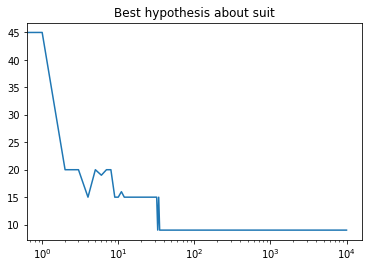

In [3]:
plt.plot(best_hyps)
plt.title('Best hypothesis about suit')
plt.xscale('log')
plt.show()
stated_hyp_about_suits = hyps_about_suit[best_hyps[-1]]

Text(0.5, 1.0, 'Number of best hypotheses about suit')

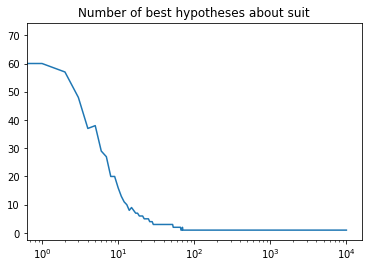

In [4]:
plt.plot(num_of_best_hyps)
plt.xscale('log')
plt.title('Number of best hypotheses about suit')

# Карты по номиналам
Варианты гипотез про номиналы карт намного больше, чем для мастей, поэтому все 10000 экспериментов не будем пересчитывать - в момент, когда останется одна превалирующая гипотеза (с вероятностью больше 0.99), алгоритм останавливаем.

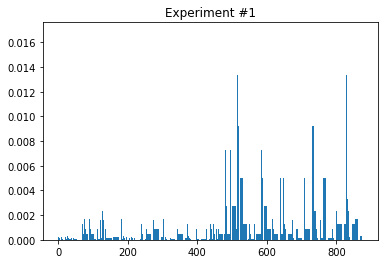

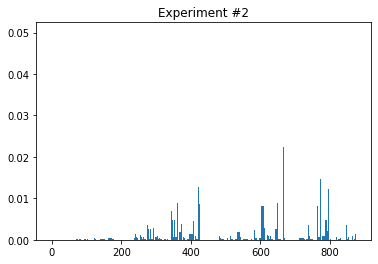

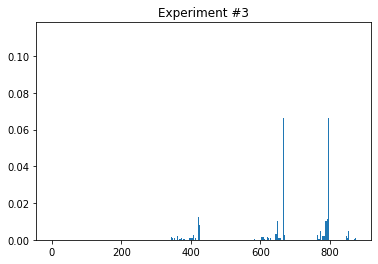

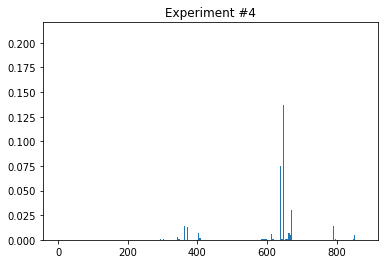

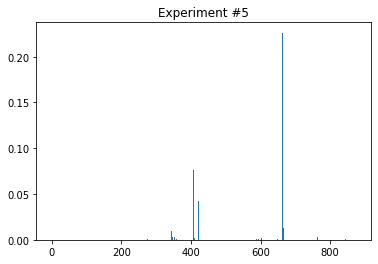

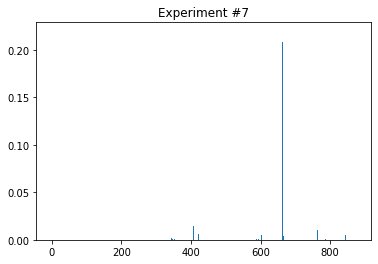

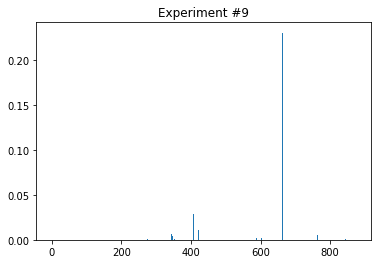

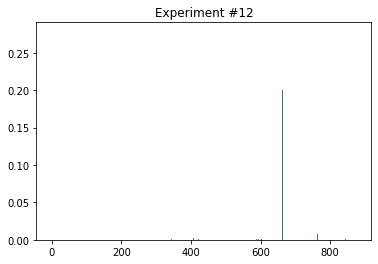

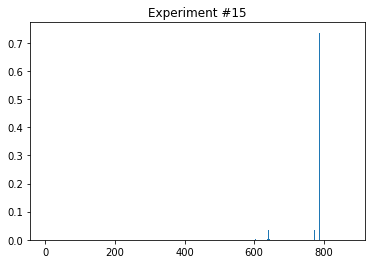

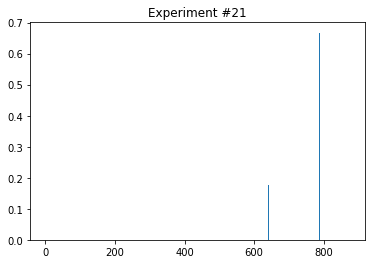

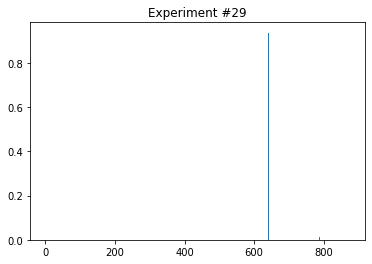

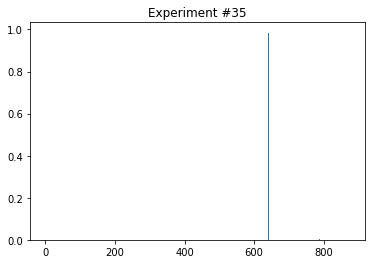

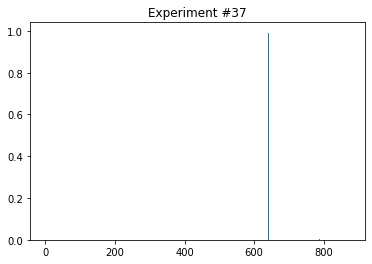

In [5]:

def pi_set_value(hyp, set_of_values):
    all_perms = list(itertools.product(list(hyp), repeat=d))
    sum_p = 0
    for perm in all_perms:
        p = 1
        hyp_values = {s: hyp[s] for s in list_of_values}
        for k in range(d):
            if set_of_values[k][1] == perm[k]:
                p *= 1 - p2
            else:
                p *= p2 / (len(list_of_values) - 1)
            p *= hyp_values[perm[k]] / (N - k)
            hyp_values[perm[k]] -= 1
            if hyp_values[perm[k]] < 0:
                p = 0
                break
        sum_p += p
    return sum_p


hyps_about_value = combs_with_sum(list(list_of_values), N, 4)

probs = [1 for k in range(len(hyps_about_value))]
best_hyps = []
num_of_best_hyps = []
prev_num_of_hyps = 2 * len(hyps_about_value)
for i in range(n_exp):
    for k in range(len(hyps_about_value)):
        probs[k] *= pi_set_value(hyps_about_value[k], info_list[i])
    probs = [pr / np.sum(probs) for pr in probs]
    sum_p = 0
    num_hyps = 0
    for pr in sorted(probs, reverse=True):
        sum_p += pr
        num_hyps += 1
        if sum_p > 0.99:
            break
    num_of_best_hyps.append(num_hyps)
    best_hyps.append(np.argmax(probs))
    if num_hyps / prev_num_of_hyps < 0.7:
        prev_num_of_hyps = num_hyps
        plt.bar(range(len(probs)), probs)
        plt.title('Experiment #' + str(i + 1))
        plt.show()
    if num_hyps == 1:
        break

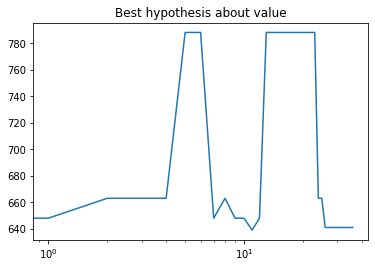

In [6]:
plt.plot(best_hyps)
plt.title('Best hypothesis about value')
plt.xscale('log')
plt.show()
stated_hyp_about_values = hyps_about_value[best_hyps[-1]]

Text(0.5, 1.0, 'Number of best hypotheses about value')

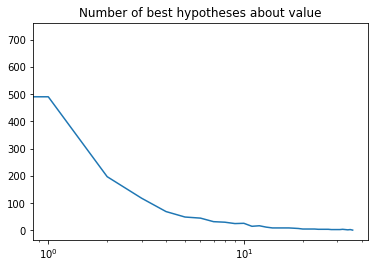

In [7]:
plt.plot(num_of_best_hyps)
plt.xscale('log')
plt.title('Number of best hypotheses about value')

# Гипотезы по масти и по номиналу
Гипотез про масти и номиналы слишком много. Поэтому поступаем следующим образом. Рассматриваем только те гипотезы, в которых масти соответствуют найденному наилучшему варианту.

In [8]:

def combs_fixed_suits(hyp_about_suits):
    possible_suits = [suit for suit in hyp_about_suits if hyp_about_suits[suit] > 0]
    dct = {suit: hyp_about_suits[suit] for suit in possible_suits}
    num = sum(dct.values())
    if len(list(dct)) == 0:
        return [[]]
    if len(list(dct)) == 1:
        return [[[possible_suits[0], val[i]] for i in range(num)] for val in
                list(itertools.combinations(list_of_values, num))]
    else:
        combs = []
        suit0 = possible_suits[0]
        possible_suits0 = possible_suits[1:]
        dct0 = {suit: hyp_about_suits[suit] for suit in possible_suits0}
        for comb in combs_fixed_suits(dct0):
            for comb0 in combs_fixed_suits({suit0: hyp_about_suits[suit0]}):
                combs.append(comb + comb0)
        return combs


hyps_about_suit_and_value = combs_fixed_suits(stated_hyp_about_suits)

Гипотез все равно много, поэтому останавливаем алгоритм, когда остается одна превалирующая гипотеза.

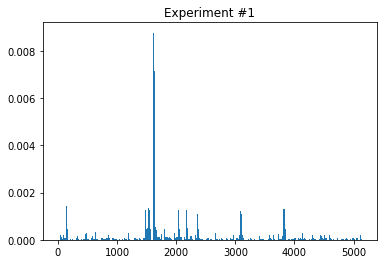

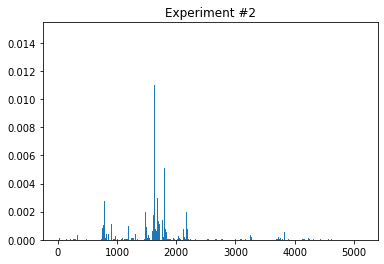

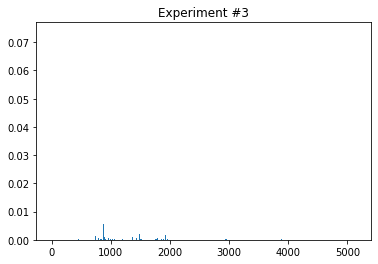

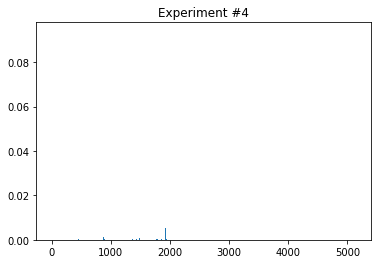

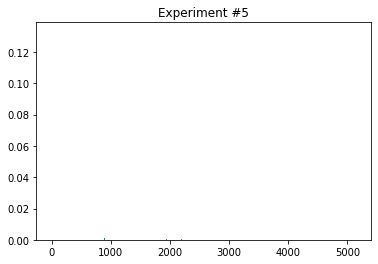

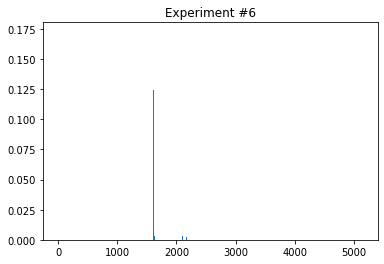

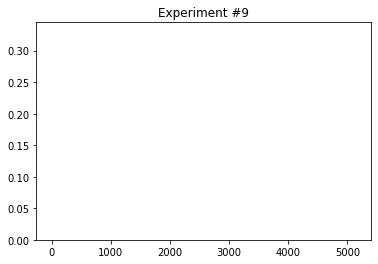

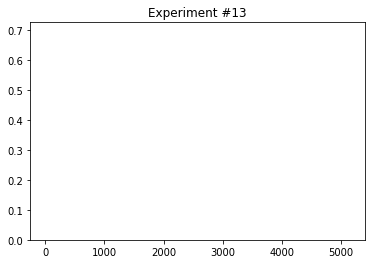

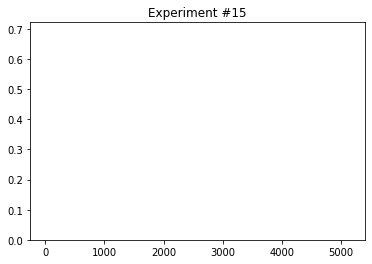

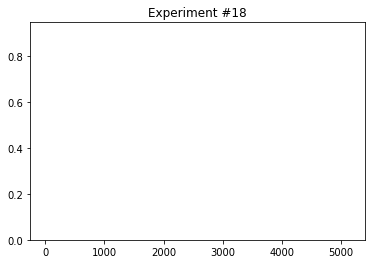

In [9]:
# карты по мастям и номиналам
m = len(list_of_values)


def pi_set_suit_and_value(hyp, set_of_suits_and_values):
    all_perms = list(itertools.permutations(hyp, d))
    sum_p = 0
    for perm in all_perms:
        p = 1
        for k in range(d):
            if set_of_suits_and_values[k][0] == perm[k][0]:
                p *= 1 - p1
            else:
                p *= p1 / 3
            if set_of_suits_and_values[k][1] == perm[k][1]:
                p *= 1 - p2
            else:
                p *= p2 / (m - 1)
            p /= N - k
        sum_p += p
    return sum_p


probs = [1 for k in range(len(hyps_about_suit_and_value))]
best_hyps = []
num_of_best_hyps = []
prev_num_of_hyps = 2 * len(hyps_about_suit_and_value)
for i in range(n_exp):
    for k in range(len(hyps_about_suit_and_value)):
        probs[k] *= pi_set_suit_and_value(hyps_about_suit_and_value[k], info_list[i])
    probs = [pr / np.sum(probs) for pr in probs]
    sum_p = 0
    num_hyps = 0
    for pr in sorted(probs, reverse=True):
        sum_p += pr
        num_hyps += 1
        if sum_p > 0.9:
            break
    num_of_best_hyps.append(num_hyps)
    best_hyps.append(np.argmax(probs))
    if num_hyps / prev_num_of_hyps < 0.7:
        prev_num_of_hyps = num_hyps
        plt.bar(range(len(probs)), probs)
        plt.title('Experiment #' + str(i + 1))
        plt.show()
    if num_hyps == 1:
        break

In [10]:
h = 0
stated_hyp_about_suits_and_values = []
for i in range(best_hyps.__len__()):
    picks = 0
    bubs = 0
    crest = 0
    chervs = 0
    values = {}
    for j in list_of_values:
        values.setdefault(j, 0)
    h = best_hyps[i]
    suits_and_values = hyps_about_suit_and_value[h]
    for j in range(suits_and_values.__len__()):
        suitt, value = suits_and_values[j]
        if suitt == '♠':
            picks += 1
        elif suitt == '♢':
            bubs += 1
        elif suitt == '♡':
            chervs += 1
        else: crest += 1
        values[value] += 1
    continue_ = True
    for key in stated_hyp_about_values:
        if stated_hyp_about_values[key] != values[key]:
            continue_= False
            break
    if continue_:
        for j in range(suits_and_values.__len__()):
            a = suits_and_values[j]
            suitt = a[0]
            if suitt == '♠':
                picks -= 1
            elif suitt == '♢':
                bubs -= 1
            elif suitt == '♡':
                chervs -= 1
            else: crest -= 1
    if picks + chervs + crest + bubs == 0:
        stated_hyp_about_suits_and_values = suits_and_values
        break
stated_hyp_about_suits_and_values

[['♣', '7'], ['♢', '4'], ['♢', 'A'], ['♠', '2'], ['♠', '4'], ['♠', '10']]

In [11]:
stated_hyp_about_suits

{'♠': 3, '♢': 2, '♣': 1, '♡': 0}

In [12]:
stated_hyp_about_values

{'5': 0, 'A': 1, '10': 1, '3': 0, '7': 1, '4': 2, '2': 1}

Видим, что гипотезы соответствуют друг другу.

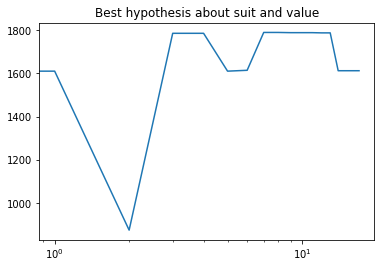

In [13]:
plt.plot(best_hyps)
plt.title('Best hypothesis about suit and value')
plt.xscale('log')
plt.show()

Text(0.5, 1.0, 'Number of best hypotheses about suit and value')

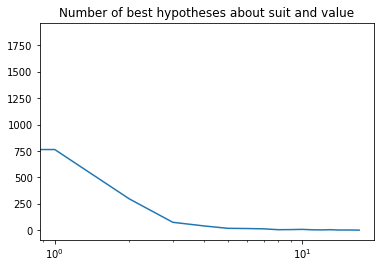

In [14]:
plt.plot(num_of_best_hyps)
plt.xscale('log')
plt.title('Number of best hypotheses about suit and value')

2a. Определить приближенно карты у ведущего исходя из средних частот их появления. Построить соответствующие графики изменения частот появления карт в зависимости от опыта.
2b. Сравнить результаты с п. 1.

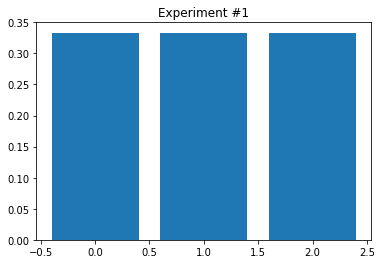

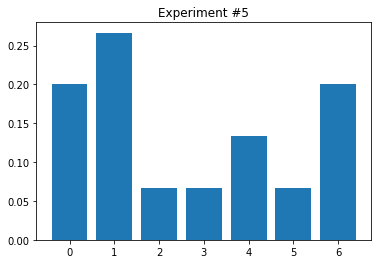

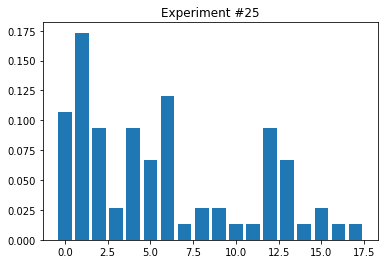

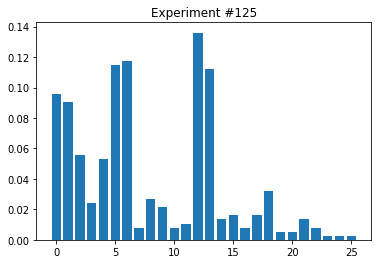

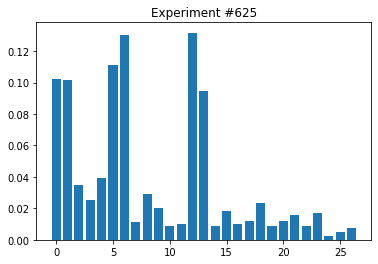

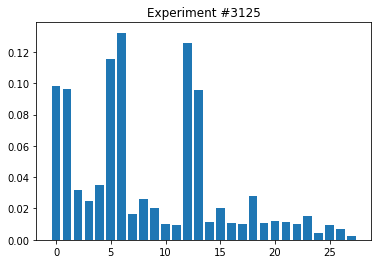

In [15]:
fr_cards = {}
for i in range(n_exp):
    for item in info_list[i]:
        card = item[0] + item[1]
        if card in fr_cards:
            fr_cards[card] += 1
        else:
            fr_cards[card] = 1
    if i in [5 ** k - 1 for k in range(20)]:
        rel_fr_cards = {card: fr_cards[card] / sum(fr_cards.values()) for card in fr_cards}
        plt.bar(range(len(list(fr_cards))), list(rel_fr_cards.values()))
        plt.title('Experiment #' + str(i + 1))
        plt.show()
hyp_fr = []
for w in sorted(fr_cards, key=fr_cards.get, reverse=True)[:N]:
    hyp_fr.append(w)

In [16]:
hyp_fr

['♠4', '♢4', '♠2', '♠10', '♣7', '♢A']

Мы видим, что результат совпадает с найденным по формуле Байеса. При этом на последней диаграмме рассеяния визуально заметно, что 6 карт встречаются значительно чаще других - это и будут карты ведущего.
